# Fine Tuning ResNet50 for ICB

In [1]:
import gc
import lib
import itertools
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras as kr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels

%matplotlib inline

[00:37:03] Library functions loaded.


In [2]:
# Implementation Dependant Globals
REQUIRED_DIMENSIONS = (300, 300)
TRAIN_BATCH_SIZE = 10
VALIDATION_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10

# Import dataset
%run DataPreparation.ipynb 

[00:37:04] Data preparation started.
[00:37:04] Loaded custom functions.
(SKIPPED) Found a non image file:  ./dataset/validation/non_biomass/metal282 - Shortcut.lnk
[Non Processed Classifier Input Data]
Raw pixels matrix: 243.63MB
Raw features matrix: 1.85MB
[00:37:14] Loaded raw congregates of images, features and labels.
[Non Augmented Generators]
Found 248 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
[Augmented Generators]
Found 248 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
[00:37:15] Loaded all generators.
[Total Info]
Number of images: 924
Size of images: 0.01MB
[00:37:15] Data preperation completed!
Time taken: 10.844212055206299 seconds.


#### Fetch & Download ResNet50

In [3]:
# For memory purposes
gc.collect()

# Fetch ResNet50 implementation from keras
resnet50 = kr.applications.resnet50
ResNet50 = resnet50.ResNet50

resnet_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape= REQUIRED_DIMENSIONS + (3,)
)

#### Build Fine Tuned Model

In [4]:
# Ease of Access
Model, Dropout, Flatten, Dense = kr.models.Model, kr.layers.Dropout, kr.layers.Flatten, kr.layers.Dense

FC_LAYERS = [1024, 1024]
dropout = 0.5

for layer in resnet_model.layers:
    layer.trainable = False

output = resnet_model.output
output = Flatten()(output)

for fc in FC_LAYERS:
    # New FC layer, random init
    output = Dense(fc, activation='relu')(output) 
    output = Dropout(dropout)(output)

# New softmax layer
predictions = Dense(len(CLASSES), activation='softmax')(output) 

# Finally join everything
model = Model(inputs=resnet_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

#### Train Model - Warmup

In [5]:
model.compile(
    kr.optimizers.SGD(lr=0.0001, momentum=0.9), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

warmup_history = model.fit_generator(
    train_set, 
    epochs=30, 
    workers=8, 
    steps_per_epoch=train_set.samples/train_set.batch_size, 
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True,
)

warmup_history.plot_title = "Warmup"

Epoch 1/30
50/49 [==============================] - 35s 696ms/step - loss: 2.6686 - accuracy: 0.6270 - val_loss: 1.2539 - val_accuracy: 0.7817
Epoch 2/30
50/49 [==============================] - 31s 622ms/step - loss: 1.6945 - accuracy: 0.7681 - val_loss: 1.1054 - val_accuracy: 0.7641
Epoch 3/30
50/49 [==============================] - 31s 625ms/step - loss: 0.8162 - accuracy: 0.8306 - val_loss: 1.0961 - val_accuracy: 0.7359
Epoch 4/30
50/49 [==============================] - 32s 634ms/step - loss: 0.5902 - accuracy: 0.8569 - val_loss: 1.5161 - val_accuracy: 0.6514
Epoch 5/30
50/49 [==============================] - 31s 628ms/step - loss: 0.5234 - accuracy: 0.8710 - val_loss: 0.5071 - val_accuracy: 0.8310
Epoch 6/30
50/49 [==============================] - 32s 633ms/step - loss: 0.2838 - accuracy: 0.9194 - val_loss: 0.8297 - val_accuracy: 0.7570
Epoch 7/30
50/49 [==============================] - 31s 623ms/step - loss: 0.3276 - accuracy: 0.9093 - val_loss: 1.0374 - val_accuracy: 0.7007

14/14 [==============================] - 3s 222ms/step
              precision    recall  f1-score   support

     biomass       0.68      1.00      0.81        70
 non_biomass       1.00      0.53      0.69        70

    accuracy                           0.76       140
   macro avg       0.84      0.76      0.75       140
weighted avg       0.84      0.76      0.75       140

Normalized confusion matrix


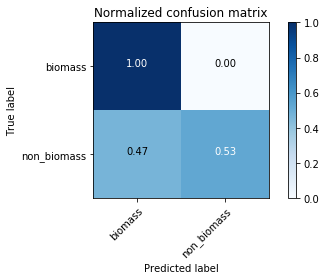

In [6]:
# Make predictions
predictions = model.predict_generator(test_set, steps=test_set.samples/test_set.batch_size, verbose=1)
normalised_predictions = np.argmax(predictions, axis=1)

# Print out scikit report
print(classification_report(test_set.classes, normalised_predictions, target_names=CLASSES))

# Draw confusion matrix
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, CLASSES)

#### Train Model - Final

In [7]:
# Reset validaiton & train set generators
train_set.reset()
validation_set.reset()

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

model.compile(
    kr.optimizers.SGD(lr=0.0001, momentum=0.9), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

final_history = model.fit_generator(
    train_set, 
    epochs=30, 
    workers=8, 
    steps_per_epoch=train_set.samples/train_set.batch_size, 
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True,
)

final_history.plot_title = "Final"

Epoch 1/30
50/49 [==============================] - 31s 621ms/step - loss: 0.0741 - accuracy: 0.9798 - val_loss: 0.8599 - val_accuracy: 0.7746
Epoch 2/30
50/49 [==============================] - 31s 621ms/step - loss: 0.0571 - accuracy: 0.9798 - val_loss: 1.2694 - val_accuracy: 0.7289
Epoch 3/30
50/49 [==============================] - 31s 613ms/step - loss: 0.0802 - accuracy: 0.9798 - val_loss: 0.9831 - val_accuracy: 0.7606
Epoch 4/30
50/49 [==============================] - 31s 616ms/step - loss: 0.0845 - accuracy: 0.9738 - val_loss: 1.1973 - val_accuracy: 0.7359
Epoch 5/30
50/49 [==============================] - 31s 619ms/step - loss: 0.0686 - accuracy: 0.9798 - val_loss: 1.1917 - val_accuracy: 0.7465
Epoch 6/30
50/49 [==============================] - 31s 629ms/step - loss: 0.0633 - accuracy: 0.9778 - val_loss: 1.1183 - val_accuracy: 0.7289
Epoch 7/30
50/49 [==============================] - 31s 629ms/step - loss: 0.0597 - accuracy: 0.9819 - val_loss: 0.9090 - val_accuracy: 0.7782

14/14 [==============================] - 3s 224ms/step
              precision    recall  f1-score   support

     biomass       0.71      1.00      0.83        70
 non_biomass       1.00      0.60      0.75        70

    accuracy                           0.80       140
   macro avg       0.86      0.80      0.79       140
weighted avg       0.86      0.80      0.79       140

Normalized confusion matrix


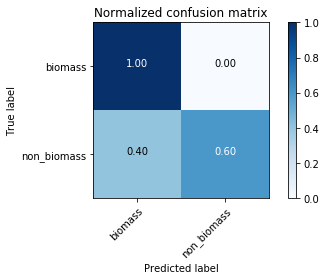

In [8]:
# Reset
test_set.reset()

# Make predictions
predictions = model.predict_generator(test_set, steps=test_set.samples/test_set.batch_size, verbose=1)
normalised_predictions = np.argmax(predictions, axis=1)

# Print out scikit report
print(classification_report(test_set.classes, normalised_predictions, target_names=CLASSES))

# Draw confusion matrix
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, CLASSES)

#### Visualising Results

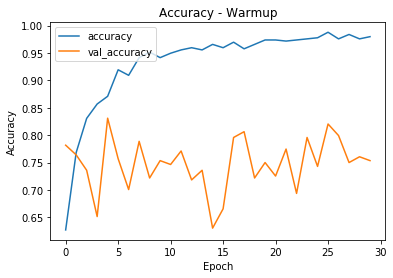

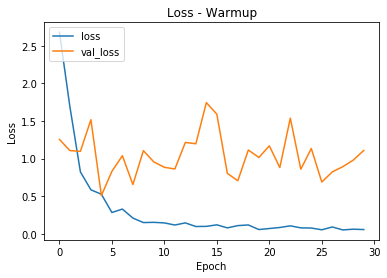

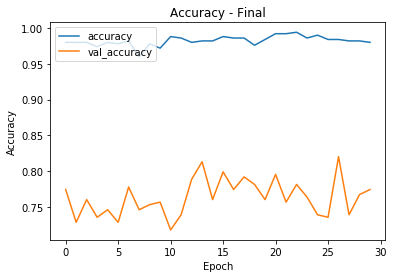

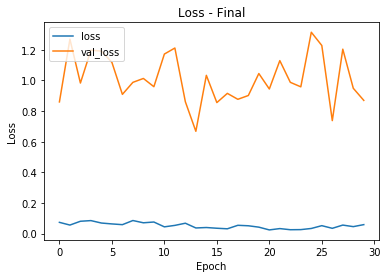

In [9]:
global_history = [warmup_history, final_history]

for history in global_history:
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title("Accuracy - " + history.plot_title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss - " + history.plot_title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [10]:
model.save('app\\trained_models\\ResNet50')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: app\trained_models\ResNet50\assets
